# 🧠 Unsupervised Graph Representation Learning using GCN (Graph Convolutional Network)

## 📌 Introduction

Graph representation learning aims to encode nodes, edges, or entire graphs into low-dimensional vector spaces (embeddings) that preserve graph topology and semantics. In the **unsupervised setting**, the model learns to embed nodes without using label supervision. One common approach is to train a model to reconstruct the adjacency matrix or predict links between nodes.

**Graph Convolutional Networks (GCNs)** can be adapted for unsupervised learning by designing appropriate loss functions — for example, by reconstructing the graph structure from node embeddings.

---

## 🧮 Mathematical Formulation

### Graph Definitions

Let:  
- $G = (V, E)$ be a graph with $n = |V|$ nodes and $|E|$ edges.  
- $A \in \mathbb{R}^{n \times n}$ be the adjacency matrix (binary, symmetric).  
- $X \in \mathbb{R}^{n \times d}$ be the node feature matrix.  
- $\hat{A}$ be the reconstructed adjacency matrix.

### Encoder (GCN Layers)

We learn node embeddings $Z \in \mathbb{R}^{n \times d'}$ via a GCN:

$$
Z = \text{GCN}(X, A) = \tilde{D}^{-1/2} \tilde{A} \tilde{D}^{-1/2} X W
$$

Where:  
- $\tilde{A} = A + I$ is the adjacency matrix with self-loops.  
- $\tilde{D}$ is the degree matrix of $\tilde{A}$.  
- $W$ is a learnable weight matrix.

### Decoder (Inner Product)

We reconstruct the adjacency matrix using the inner product of embeddings:

$$
\hat{A}_{ij} = \sigma(z_i^\top z_j)
$$

Where $\sigma$ is the sigmoid function, and $z_i$ is the embedding of node $i$.

### Loss Function

We minimize the **binary cross-entropy** between real and reconstructed adjacency:

$$
\mathcal{L} = - \sum_{i,j} \left[ A_{ij} \log \hat{A}_{ij} + (1 - A_{ij}) \log(1 - \hat{A}_{ij}) \right]
$$

---

## 🧪 PyTorch Geometric Implementation




Epoch 20, Loss: 1.3195
Epoch 40, Loss: 1.1711
Epoch 60, Loss: 1.1430
Epoch 80, Loss: 1.1240
Epoch 100, Loss: 1.1149
Epoch 120, Loss: 1.1089
Epoch 140, Loss: 1.1106
Epoch 160, Loss: 1.1046
Epoch 180, Loss: 1.1038
Epoch 200, Loss: 1.1042


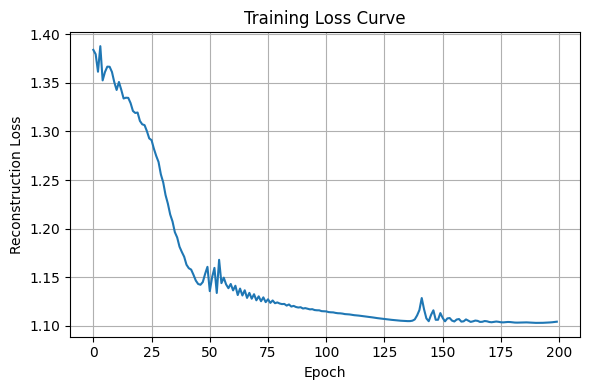

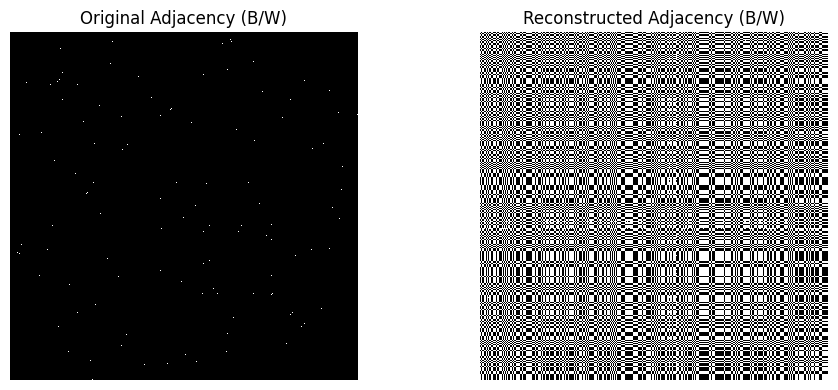

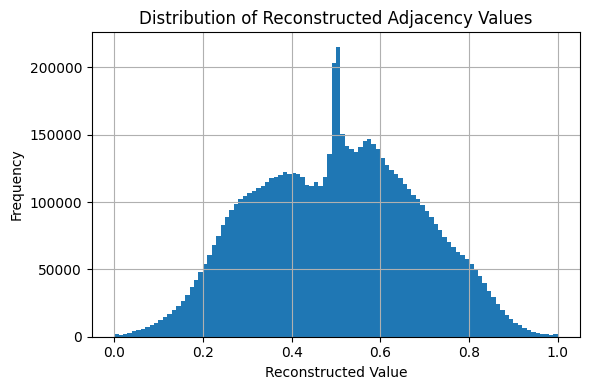

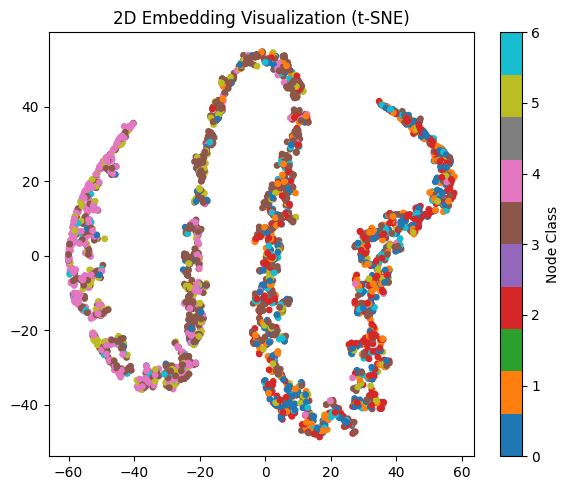

Learned embeddings shape: (2708, 64)


In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.nn import GCNConv
from torch_geometric.utils import to_scipy_sparse_matrix
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE

# === 1. Load and Prepare the Cora Dataset ===
dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())
data = dataset[0]

# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = data.to(device)

# Convert edge_index to a dense adjacency matrix (torch tensor)
adj = to_scipy_sparse_matrix(data.edge_index, num_nodes=data.num_nodes)
adj = torch.FloatTensor(adj.todense()).to(device)

# === 2. Define GCN Encoder ===
class GCNEncoder(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        return self.conv2(x, edge_index)

# Instantiate model and optimizer
model = GCNEncoder(in_channels=dataset.num_features, hidden_channels=128, out_channels=64).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

# === 3. Define Weighted Reconstruction Loss ===
def reconstruction_loss(z, adj):
    """
    Reconstructs the adjacency matrix from embeddings z using dot-product,
    and computes weighted binary cross-entropy loss to handle sparsity.
    """
    recon_adj = torch.sigmoid(torch.matmul(z, z.t()))  # [N, N] similarity matrix
    adj_binary = (adj > 0).float()  # binarize original adjacency
    
    # Compute class weight to address imbalance
    pos_weight = (adj_binary.numel() - adj_binary.sum()) / adj_binary.sum()
    weight_matrix = adj_binary * (pos_weight - 1) + 1
    
    loss = F.binary_cross_entropy(recon_adj, adj_binary, weight=weight_matrix)
    return loss

# === 4. Training Loop ===
def train():
    model.train()
    optimizer.zero_grad()
    z = model(data.x, data.edge_index)
    loss = reconstruction_loss(z, adj)
    loss.backward()
    optimizer.step()
    return loss.item(), z

losses = []
for epoch in range(1, 201):
    loss, embeddings = train()
    losses.append(loss)
    if epoch % 20 == 0:
        print(f"Epoch {epoch}, Loss: {loss:.4f}")

# Convert embeddings to numpy
embeddings = embeddings.detach().cpu().numpy()

# === 5. Visualization ===

# 5.1 Plot training loss curve
plt.figure(figsize=(6, 4))
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Reconstruction Loss")
plt.title("Training Loss Curve")
plt.grid(True)
plt.tight_layout()
plt.show()

# 5.2 Plot original and reconstructed adjacency matrices (binary images)

# Get reconstruction
with torch.no_grad():
    z = model(data.x, data.edge_index)
    recon_adj = torch.sigmoid(torch.matmul(z, z.t())).cpu().numpy()
    recon_adj_binary = (recon_adj > 0.5).astype(np.float32)

# Binarize the original adjacency
adj_binary = (adj.cpu().numpy() > 0).astype(np.float32)

# Show adjacency matrices
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(adj_binary, cmap="gray", interpolation="none")
plt.title("Original Adjacency (B/W)")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(recon_adj_binary, cmap="gray", interpolation="none")
plt.title("Reconstructed Adjacency (B/W)")
plt.axis("off")

plt.tight_layout()
plt.show()

# 5.3 Plot histogram of reconstructed values
plt.figure(figsize=(6, 4))
plt.hist(recon_adj.ravel(), bins=100)
plt.title("Distribution of Reconstructed Adjacency Values")
plt.xlabel("Reconstructed Value")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

# 5.4 t-SNE visualization of learned embeddings
tsne = TSNE(n_components=2, init='pca', random_state=42)
z_2d = tsne.fit_transform(embeddings)

plt.figure(figsize=(6, 5))
scatter = plt.scatter(z_2d[:, 0], z_2d[:, 1], c=data.y.cpu().numpy(), cmap='tab10', s=15)
plt.title("2D Embedding Visualization (t-SNE)")
plt.colorbar(scatter, label='Node Class')
plt.tight_layout()
plt.show()

# Print final embedding shape
print("Learned embeddings shape:", embeddings.shape)
